#### ASTR 3890 - Selected Topics: Data Science for Large Astronomical Surveys (Spring 2022)
***N. Hernitschek***
___

# Homework 8
### Due: Monday, Mar 28th at 11.00am CST

The completed lecture notebook must also be submitted by 11:00am Central Time on March 28th.

---

## Problem 1

**Phased LINEAR light curves**


Using the code snipplet below, load LINEAR light curves.


Extend the code to:

a) plot the light curves

b) compute the best period using a Fourier transformation

c) plot the phased data and best-fit curves.

d) Solve the problem by using Lomb-Scargle Periodograms.


In [86]:

from __future__ import print_function, division

import numpy as np
from matplotlib import pyplot as plt

from astroML.utils.decorators import pickle_results
from astroML.time_series import search_frequencies, lomb_scargle, MultiTermFit
from astroML.datasets import fetch_LINEAR_sample

%matplotlib inline

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=False)
import matplotlib
matplotlib.rc('_internal', classic_mode=True)

#------------------------------------------------------------
# Load the dataset
data = fetch_LINEAR_sample()
ids = [14752041, 1009459, 10022663, 10025796, 11375941, 18525697]


#------------------------------------------------------------
# Compute the best frequencies
@pickle_results('LINEAR_LS.pkl')
def compute_best_frequencies(ids, n_eval=10000, n_retry=5, generalized=True):
    results = {}
    for i in ids:
        t, y, dy = data[i].T
        print(" - computing power for {0} ({1} points)".format(i, len(t)))
        kwargs = dict(generalized=generalized)
        omega, power = search_frequencies(t, y, dy, n_eval=n_eval,
                                          n_retry=n_retry,
                                          LS_kwargs=kwargs)
        results[i] = [omega, power]

    return results

results = compute_best_frequencies(ids, n_eval=10000, n_retry=5)


@pickle_results: using precomputed results from 'LINEAR_LS.pkl'


### Solution

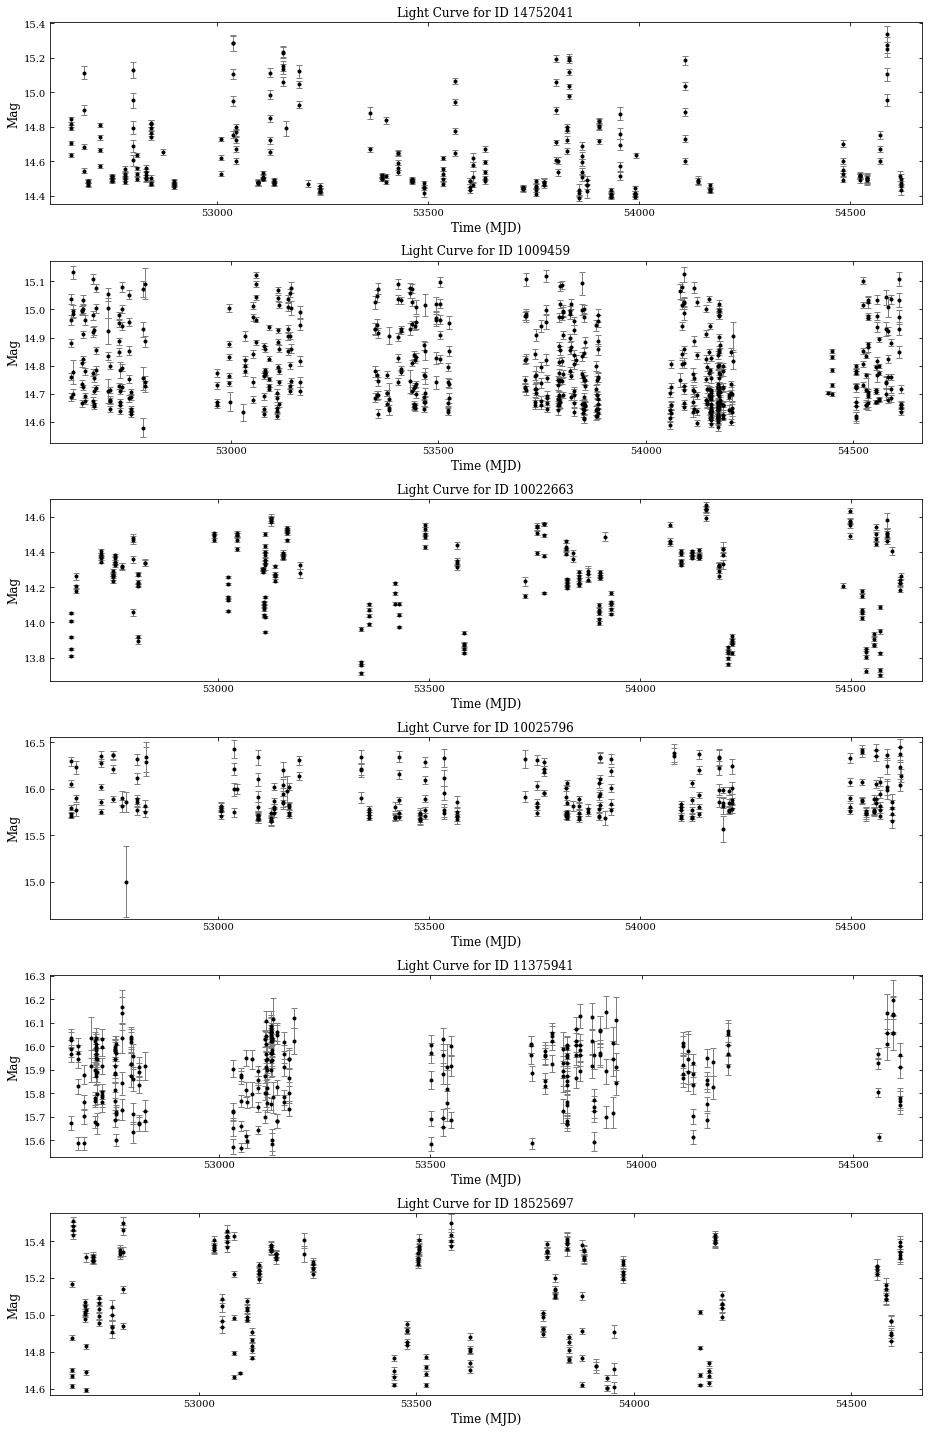

In [87]:
%matplotlib inline

# a) Plot the light curves
fig, ax = plt.subplots(6,1)
fig.set_figheight(20)
fig.set_figwidth(13)


# Iterate through IDs
for idx, i in enumerate(ids):
    t, y, dy = data[i].T
    
    # Plot light curve for each ID
    ax[idx].errorbar(t, y, dy, fmt='.k', lw=1, ecolor='gray')
    ax[idx].tick_params(axis='both', which='major', labelsize=10)
    ax[idx].set_xlabel('Time (MJD)', fontsize=12)
    ax[idx].set_ylabel('Mag', fontsize=12)
    ax[idx].set_xlim(t.min() - 50, t.max() + 50)
    ax[idx].set_ylim(y.min() - dy[np.argmin(y)] - 0.02, y.max() + dy[np.argmax(y)] + 0.02,)
    ax[idx].set_title(f'Light Curve for ID {i}', fontsize=12)
    
plt.tight_layout()
plt.show()

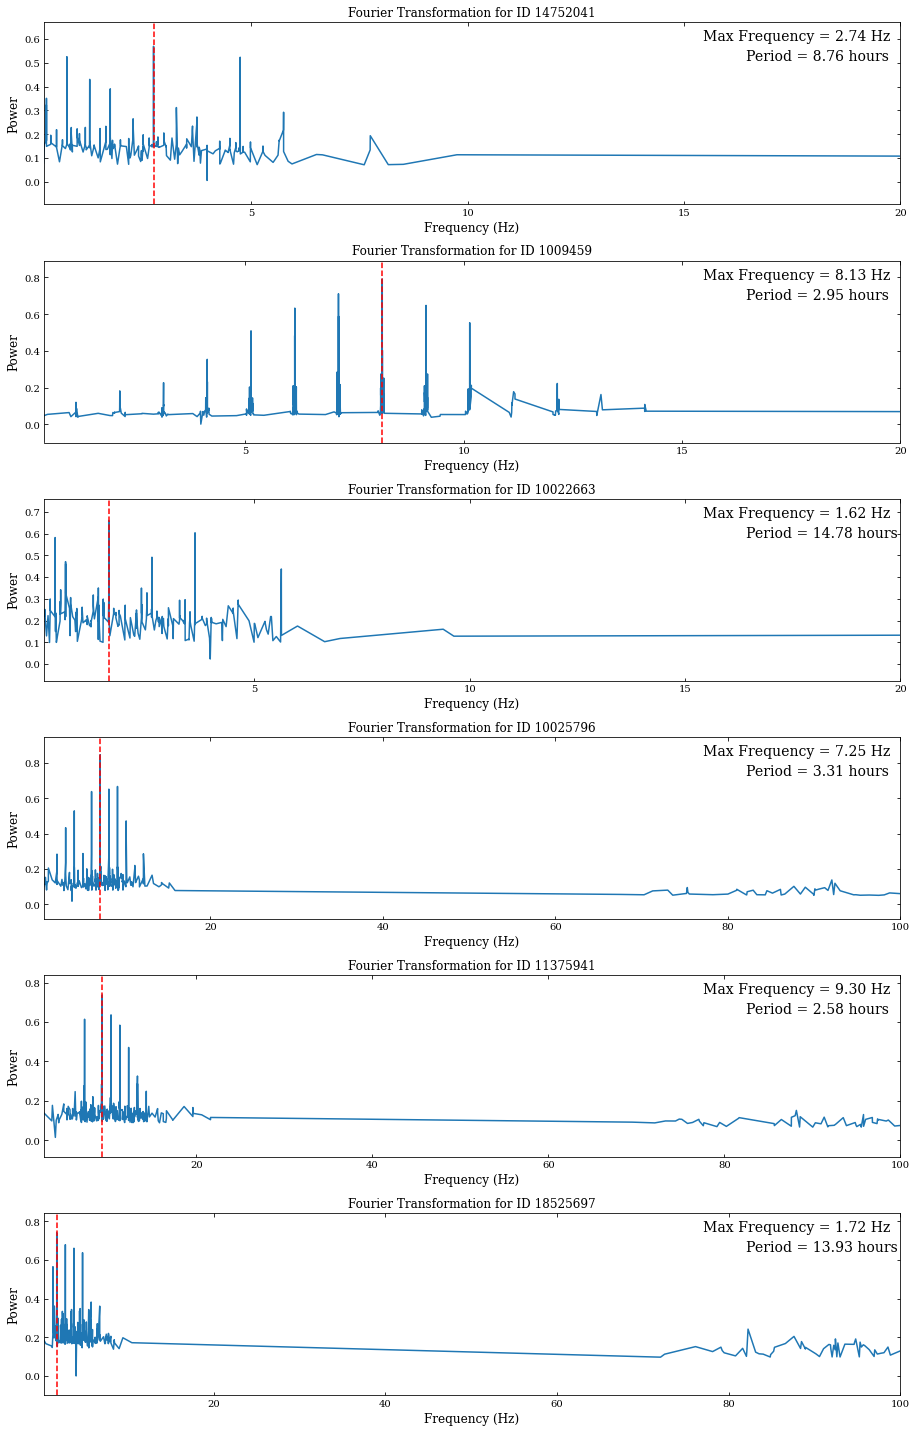

In [88]:
# b) Compute the best period using a Fourier transformation
fig, ax = plt.subplots(6,1)
fig.set_figheight(20)
fig.set_figwidth(13)

# Iterate through IDs
for idx, i in enumerate(ids):
    t, y, dy = data[i].T
    
    # Get results
    omega, power = results[i]
    max_pow_omega = omega[np.argmax(power)] # Angular frequency with max power
    
    # Convert angular frequency to ordinary frequency
    freq = omega / (2 * np.pi)
    
    # Plot power as a function of frequency (Fourier transformation)
    ax[idx].plot(freq, power)
    
    # Get frequency with max power
    max_pow = freq[np.argmax(power)]
    
    # Get best fit period using max_omega
    best_period = 2 * np.pi / max_pow_omega
    
    # Plot light curve for each ID
    ax[idx].tick_params(axis='both', which='major', labelsize=10)
    ax[idx].set_xlabel('Frequency (Hz)', fontsize=12)
    ax[idx].set_ylabel('Power', fontsize=12)
    
    if idx < 3:
        ax[idx].set_xlim(freq.min(), 20)
    else:
        ax[idx].set_xlim(freq.min(), 100)
        
    ax[idx].set_ylim(power.min() - 0.1, power.max() + 0.1)
    ax[idx].set_title(f'Fourier Transformation for ID {i}', fontsize=12)
    
    # Add text that gives the best period I calculated
    ax[idx].text(0.77, 0.96, "Max Frequency = %.2f Hz" % (max_pow),
            ha='left', va='top', transform=ax[idx].transAxes, fontsize=14)
    ax[idx].text(0.82, 0.85, "Period = %.2f hours" % (best_period * 24),
            ha='left', va='top', transform=ax[idx].transAxes, fontsize=14)
    
    # Add a red vertical line at the best omega
    ax[idx].axvline(max_pow, c='r', ls='dashed')
    
plt.tight_layout()
plt.show()

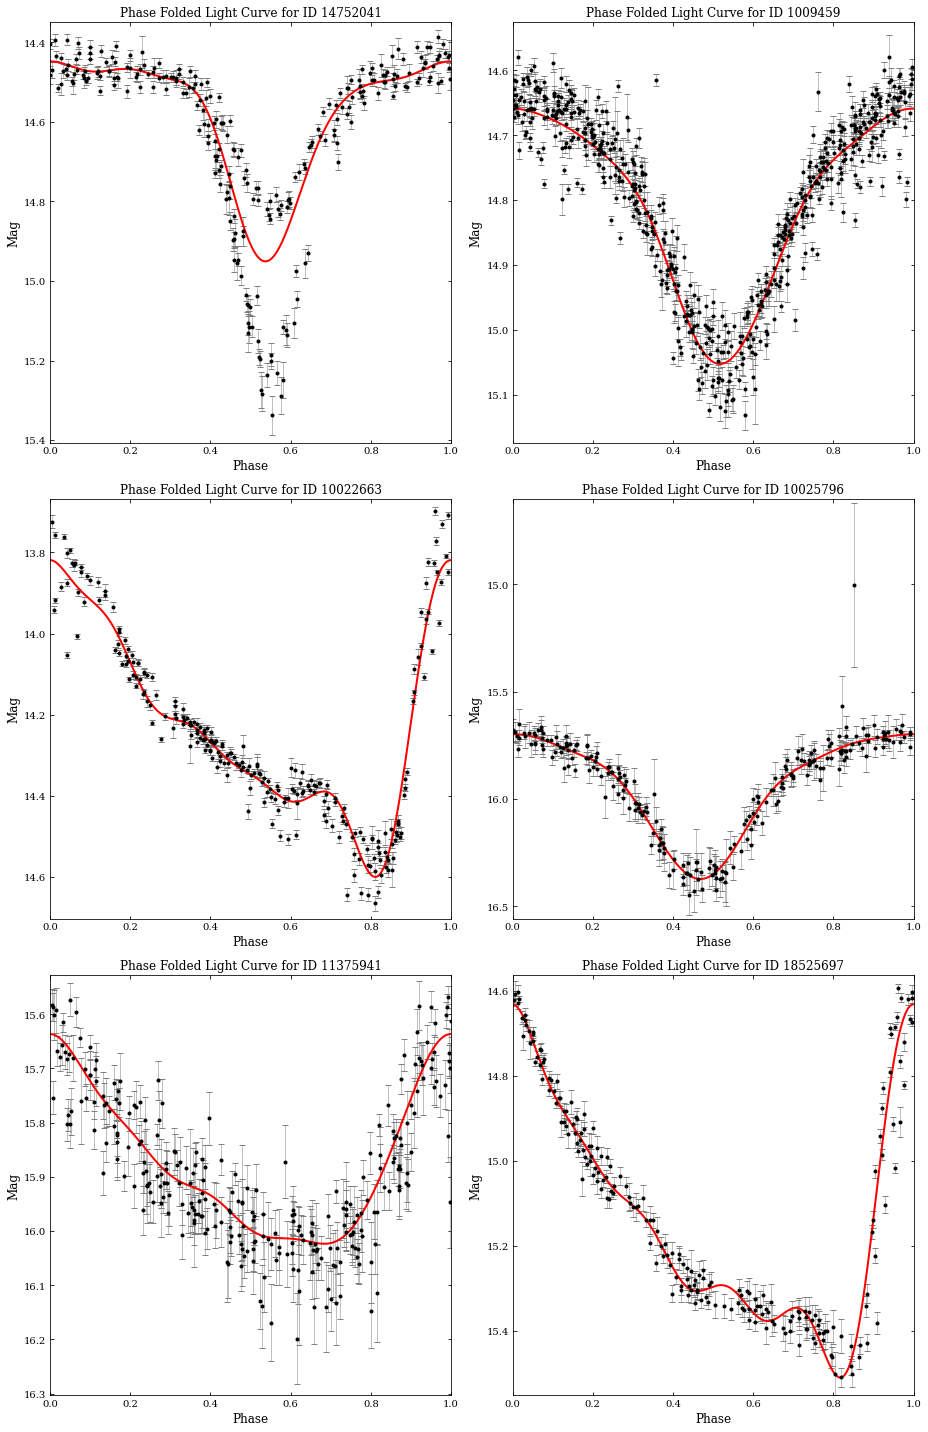

In [89]:
# c) Plot the phased data and best fit curves
fig, ax = plt.subplots(3,2)
fig.set_figheight(20)
fig.set_figwidth(13)

row = 0

# Iterate through IDs
for idx, i in enumerate(ids):
    t, y, dy = data[i].T
    
    # Get results
    omega, power = results[i]
    omega_mode = omega[np.argmax(power)]
    
    # Fit to Fourier using MultiTermFit object
    k = 5
    fr = MultiTermFit(omega_mode, k)
    fr.fit(t, y, dy)
    phase, y_fit, phase_t = fr.predict(1000, return_phased_times=True)
    
    # Get row and column of subplot
    r = idx // 2
    c = idx % 2
    
    # Plot the phased data
    ax[r][c].errorbar(phase_t, y, dy, fmt='.k', ecolor='gray', lw=0.5)
    ax[r][c].plot(phase, y_fit, 'r', markeredgecolor='red', lw=2)
    
    # Fine tune plots
    ax[r][c].tick_params(axis='both', which='major', labelsize=10)
    ax[r][c].set_xlabel('Phase', fontsize=12)
    ax[r][c].set_ylabel('Mag', fontsize=12)
    ax[r][c].set_xlim(0, 1)
    # Flip y-axis to reflect indirect relationship between magnitude and brightness
    ax[r][c].set_ylim(y.max() + dy[np.argmax(y)] + 0.02, y.min() - dy[np.argmin(y)] - 0.02)
    ax[r][c].set_title(f'Phase Folded Light Curve for ID {i}', fontsize=12)
    
plt.tight_layout()
plt.show()

Finding optimal frequency:
 - Estimated peak width = 0.00319
 - Using 5 steps per peak; omega_step = 0.000639
 - User-specified period range:  0.01 to 1.2
 - Computing periods at 975205 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00314
 - Using 5 steps per peak; omega_step = 0.000628
 - User-specified period range:  0.01 to 1.2
 - Computing periods at 992539 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0032
 - Using 5 steps per peak; omega_step = 0.000639
 - User-specified period range:  0.01 to 1.2
 - Computing periods at 974711 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.0032
 - Using 5 steps per peak; omega_step = 0.000639
 - User-specified period range:  0.01 to 1.2
 - Computing periods at 974710 steps
Zooming-in on 5 candidate peak

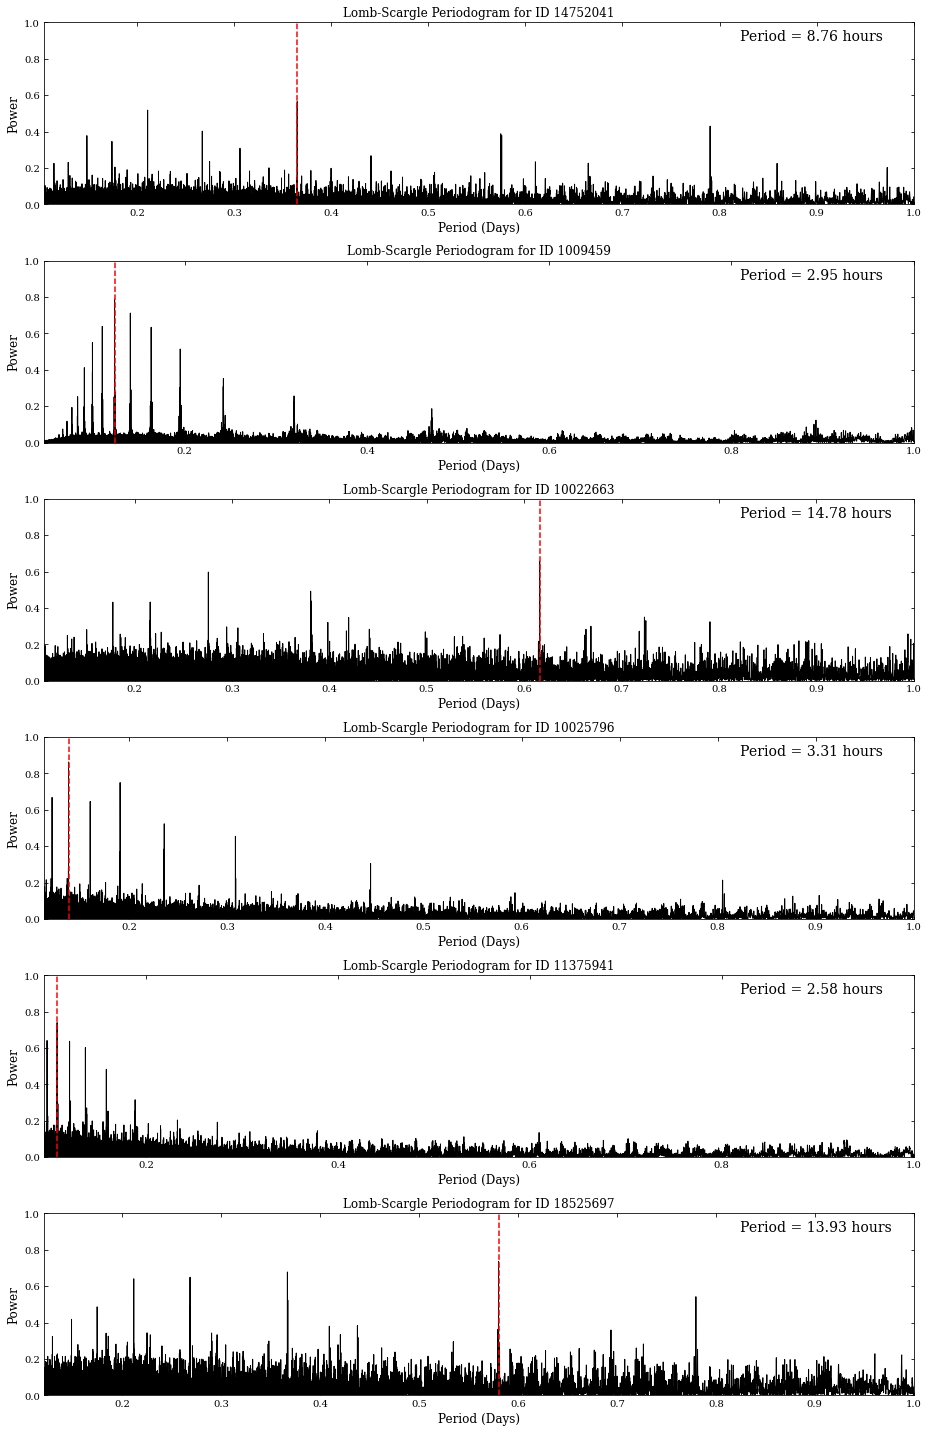

In [90]:
from gatspy.periodic import LombScargleFast

fig, ax = plt.subplots(6,1)
fig.set_figheight(20)
fig.set_figwidth(13)

# Iterate through IDs
for idx, i in enumerate(ids):
    t, y, dy = data[i].T
    
    # Compute periodogram using LombScargleFast object from gatspy
    model = LombScargleFast(fit_period=True)
    model.optimizer.period_range = (0.01, 1.2)
    model.fit(t, y, dy)
    periods, power = model.periodogram_auto(nyquist_factor=150)
    
    # Plot periodogram for each ID
    ax[idx].plot(periods, power, c='black', lw=1)
    ax[idx].tick_params(axis='both', which='major', labelsize=10)
    ax[idx].set_xlabel('Period (Days)', fontsize=12)
    ax[idx].set_ylabel('Power', fontsize=12)
    ax[idx].set_xlim(periods.min(), 1)
    ax[idx].set_ylim(0, 1)
    ax[idx].set_title(f'Lomb-Scargle Periodogram for ID {i}', fontsize=12)
    
    # Add text that gives the best period as determined by the model
    ax[idx].text(0.8, 0.96, "Period = %.2f hours" % (model.best_period * 24),
            ha='left', va='top', transform=ax[idx].transAxes, fontsize=14)
    
    # Add a red vertical line at the period determined by the model
    ax[idx].axvline(model.best_period, c='r', ls='dashed')
    
plt.tight_layout()
plt.show()